# Libraries

In [1]:
from speaker_verification import transforms as T
from speaker_verification.dataset import SpeakingFacesDataset
from speaker_verification.dataset import ValidDataset
from speaker_verification.sampler import ProtoSampler
from speaker_verification.sampler import ValidSampler
from speaker_verification.models_handmade.resnet import ResNet34
from speaker_verification.loss import PrototypicalLoss
from speaker_verification.train import train_model

import torch
from torch.utils.data import DataLoader

from speaker_verification.utils import plot_sample


In [2]:
import timm

In [3]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Default train pipeline

There are 9307 samples in the dataset.
There are 1843 samples in the dataset.


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]


Average train loss: 1.1363118886947632

Average train accuracy: 10.000000762939454


Epoch:   0%|          | 1/200 [00:31<1:44:09, 31.41s/it]


Average val eer: 38.1863921368777

Average val accuracy: 61.883522359478434



Average train loss: 1.0997118830680848

Average train accuracy: 20.000001525878908


Epoch:   1%|          | 2/200 [01:01<1:41:25, 30.74s/it]


Average val eer: 34.54821371468755

Average val accuracy: 65.2887717664912



Average train loss: 1.098993146419525

Average train accuracy: 13.333334350585938


Epoch:   2%|▏         | 3/200 [01:33<1:42:46, 31.30s/it]


Average val eer: 27.019854312023046

Average val accuracy: 73.09747285849812



Average train loss: 1.0988443970680237

Average train accuracy: 16.666667938232422


Epoch:   2%|▏         | 4/200 [02:04<1:41:59, 31.22s/it]


Average val eer: 35.31765581290152

Average val accuracy: 64.47360380255725



Average train loss: 1.098795521259308

Average train accuracy: 23.33333511352539


Epoch:   2%|▎         | 5/200 [02:29<1:33:33, 28.79s/it]


Average val eer: 35.02677071773189

Average val accuracy: 64.97522909839819



Average train loss: 1.098787498474121

Average train accuracy: 20.000001525878908


Epoch:   3%|▎         | 6/200 [03:02<1:37:48, 30.25s/it]


Average val eer: 40.11461520818066

Average val accuracy: 59.75599292508285



Average train loss: 1.098685348033905

Average train accuracy: 23.33333511352539


Epoch:   3%|▎         | 6/200 [03:09<1:42:21, 31.66s/it]


KeyboardInterrupt: 

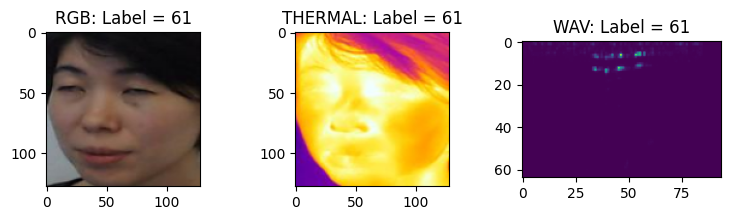

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset
ANNOTATIONS_FILE = "/workdir/annotations_file_short_SF.csv"
DATASET_DIR = '/workdir/sf_pv/data_v2'

train_dataset = SpeakingFacesDataset(ANNOTATIONS_FILE,DATASET_DIR,'train',
                                    image_transform=T.image_transform, 
                                    audio_transform=T.audio_transform)
valid_dataset = SpeakingFacesDataset(ANNOTATIONS_FILE,DATASET_DIR,'valid',
                                    image_transform=T.image_transform, 
                                    audio_transform=T.audio_transform)
                                    
print(f"There are {len(train_dataset)} samples in the dataset.")
print(f"There are {len(valid_dataset)} samples in the dataset.")
sample = train_dataset[0]
data_wav, data_rgb, data_thr, label = sample
plot_sample(data_wav, data_rgb, data_thr, label)

# sampler
train_sampler = ProtoSampler(labels = train_dataset.labels,
                                    n_batch = 10,
                                    n_ways = 3, # n_way
                                    n_support = 1, # n_shots
                                    n_query = 1)
val_sampler = ValidSampler(labels = valid_dataset.labels)

# dataloader
train_dataloader = DataLoader(dataset=train_dataset, 
                          batch_sampler=train_sampler,
                          num_workers=2, pin_memory=True
                          )

valid_dataloader = DataLoader(dataset = valid_dataset,
                              batch_sampler=val_sampler,
                              num_workers=4, pin_memory=True
                              )
# model
model = ResNet34()
model = model.to(device)

# optimizer + scheduler
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)

# loss
criterion = PrototypicalLoss(dist_type='cosine_similarity')
criterion = criterion.to(device)

# train
model = train_model(model,
                    train_dataloader, 
                    valid_dataloader,
                    train_sampler,
                    criterion,
                    optimizer,
                    scheduler,
                    device,
                    num_epochs=200)

# 1. Create validation with lists

In [3]:
# dataset
PATH2DATASET = "/workdir/sf_pv"

valid_dataset = ValidDataset(PATH2DATASET,'valid',
                            image_transform=T.image_transform, 
                            audio_transform=T.audio_transform)
                                    
print(f"There are {len(valid_dataset)} samples in the dataset.")

There are 38000 samples in the dataset.


Pairs label: 1


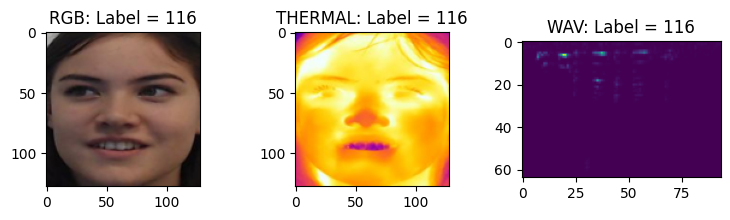

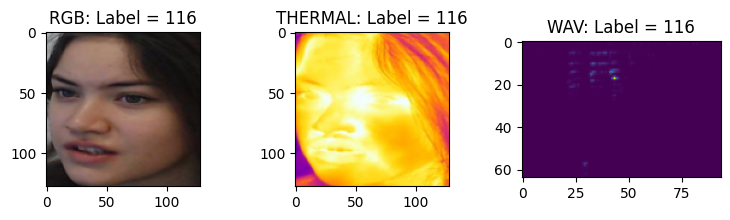

In [4]:
sample = valid_dataset[30000]
id1, id2, label = sample
id1_wav, id1_rgb, id1_thr, id1_label = id1
id2_wav, id2_rgb, id2_thr, id2_label = id2
plot_sample(id1_wav, id1_rgb, id1_thr, id1_label)
plot_sample(id2_wav, id2_rgb, id2_thr, id2_label)
print(f"Pairs label: {label}")

In [5]:
valid_dataloader = DataLoader(dataset=valid_dataset,
                            batch_size=64,
                            shuffle=True,
                            num_workers=4, 
                            pin_memory=True)

# Check different models

There are 9307 samples in the dataset.
There are 38000 samples in the dataset.
Check Train Dataset
Check Valid Dataset
Pairs label: 1


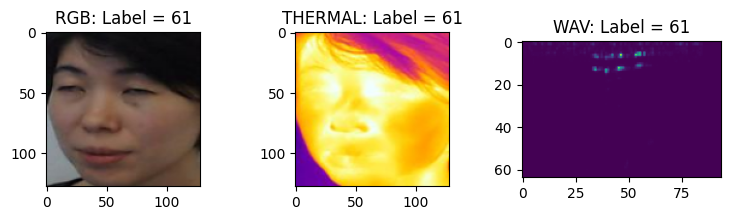

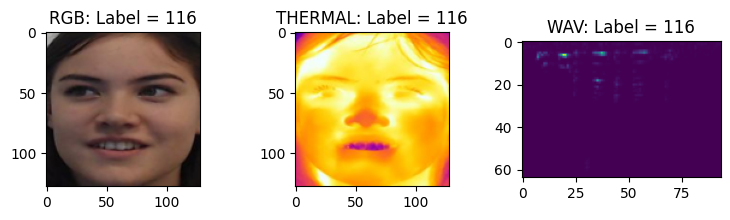

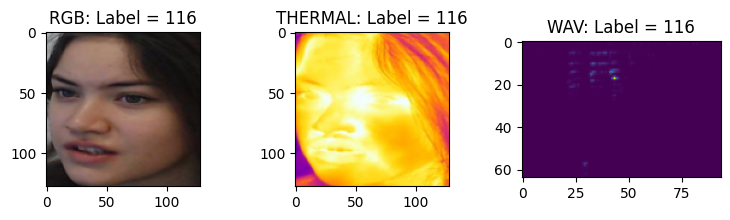

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset
ANNOTATIONS_FILE = "/workdir/annotations_file_short_SF.csv"
DATASET_DIR = '/workdir/sf_pv/data_v2'
PATH2DATASET = "/workdir/sf_pv"

train_dataset = SpeakingFacesDataset(ANNOTATIONS_FILE,DATASET_DIR,'train',
                                    image_transform=T.image_transform, 
                                    audio_transform=T.audio_transform)
valid_dataset = ValidDataset(PATH2DATASET,'valid',
                            image_transform=T.image_transform, 
                            audio_transform=T.audio_transform)
                                    
print(f"There are {len(train_dataset)} samples in the dataset.")
print(f"There are {len(valid_dataset)} samples in the dataset.")

print("Check Train Dataset")
sample = train_dataset[0]
data_wav, data_rgb, data_thr, label = sample
plot_sample(data_wav, data_rgb, data_thr, label)

print("Check Valid Dataset")
sample = valid_dataset[30000]
id1, id2, label = sample
id1_wav, id1_rgb, id1_thr, id1_label = id1
id2_wav, id2_rgb, id2_thr, id2_label = id2
plot_sample(id1_wav, id1_rgb, id1_thr, id1_label)
plot_sample(id2_wav, id2_rgb, id2_thr, id2_label)
print(f"Pairs label: {label}")

# sampler
train_sampler = ProtoSampler(labels = train_dataset.labels,
                                    n_batch = 10,
                                    n_ways = 3, # n_way
                                    n_support = 1, # n_shots
                                    n_query = 1)

# dataloader
train_dataloader = DataLoader(dataset=train_dataset, 
                          batch_sampler=train_sampler,
                          num_workers=2, pin_memory=True
                          )

valid_dataloader = DataLoader(dataset=valid_dataset,
                            batch_size=64,
                            shuffle=True,
                            num_workers=4, 
                            pin_memory=True)

In [25]:
# model
# model = ResNet34()
model = timm.create_model('resnet34', pretrained=True, num_classes=128)
model = model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /workdir/data/.torch/hub/checkpoints/resnet34-43635321.pth


In [27]:
import torch.nn.functional as F

from speaker_verification.metrics import EER_
from speaker_verification.metrics import accuracy_

In [28]:
for batch in valid_dataloader:

    id1, id2, labels = batch

    wav_id1, rgb_id1, thr_id1, label_id1 = id1
    wav_id2, rgb_id2, thr_id2, label_id2 = id2

    data_id1 = rgb_id1.to(device)
    data_id2 = rgb_id2.to(device)

    with torch.no_grad():
        id1_out = model(data_id1)
        id2_out = model(data_id2)

        cos_sim = F.cosine_similarity(id1_out, id2_out, dim=1)
        eer, scores = EER_(cos_sim, labels)
        accuracy = accuracy_(labels, scores)

    break

In [29]:
print(f"EER = {eer}")
print(f"Accuracy = {accuracy}")

EER = 35.13513513513514
Accuracy = 67.1875


In [34]:
model2 = ResNet34()
model2 = model2.to(device)

In [35]:
for batch in valid_dataloader:

    id1, id2, labels = batch

    wav_id1, rgb_id1, thr_id1, label_id1 = id1
    wav_id2, rgb_id2, thr_id2, label_id2 = id2

    data_id1 = rgb_id1.to(device)
    data_id2 = rgb_id2.to(device)

    with torch.no_grad():
        id1_out = model2(data_id1)
        id2_out = model2(data_id2)

        cos_sim = F.cosine_similarity(id1_out, id2_out, dim=1)
        eer, scores = EER_(cos_sim, labels)
        accuracy = accuracy_(labels, scores)

    break

In [36]:
print(f"EER = {eer}")
print(f"Accuracy = {accuracy}")

EER = 43.333333333333336
Accuracy = 54.6875


# CHeck new train pipeline

There are 9307 samples in the dataset.
There are 38000 samples in the dataset.
Check Train Dataset
Check Valid Dataset
Pairs label: 1


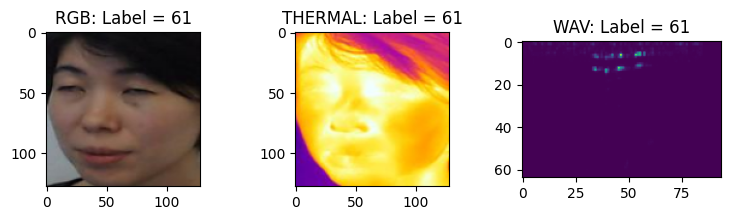

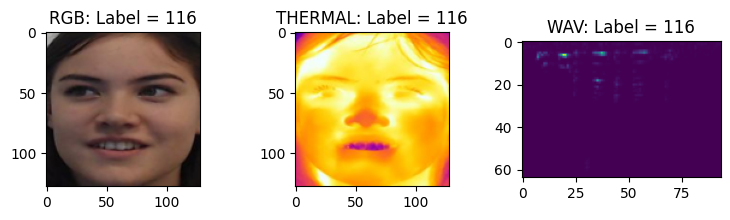

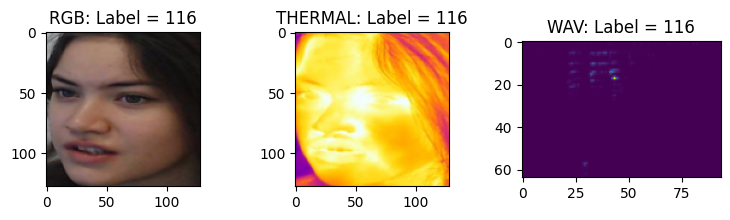

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset
ANNOTATIONS_FILE = "/workdir/annotations_file_short_SF.csv"
DATASET_DIR = '/workdir/sf_pv/data_v2'
PATH2DATASET = "/workdir/sf_pv"

train_dataset = SpeakingFacesDataset(ANNOTATIONS_FILE,DATASET_DIR,'train',
                                    image_transform=T.image_transform, 
                                    audio_transform=T.audio_transform)
valid_dataset = ValidDataset(PATH2DATASET,'valid',
                            image_transform=T.image_transform, 
                            audio_transform=T.audio_transform)
                                    
print(f"There are {len(train_dataset)} samples in the dataset.")
print(f"There are {len(valid_dataset)} samples in the dataset.")

print("Check Train Dataset")
sample = train_dataset[0]
data_wav, data_rgb, data_thr, label = sample
plot_sample(data_wav, data_rgb, data_thr, label)

print("Check Valid Dataset")
sample = valid_dataset[30000]
id1, id2, label = sample
id1_wav, id1_rgb, id1_thr, id1_label = id1
id2_wav, id2_rgb, id2_thr, id2_label = id2
plot_sample(id1_wav, id1_rgb, id1_thr, id1_label)
plot_sample(id2_wav, id2_rgb, id2_thr, id2_label)
print(f"Pairs label: {label}")

# sampler
train_sampler = ProtoSampler(labels = train_dataset.labels,
                                    n_batch = 100,
                                    n_ways = 30, # n_way
                                    n_support = 1, # n_shots
                                    n_query = 1)

# dataloader
train_dataloader = DataLoader(dataset=train_dataset, 
                          batch_sampler=train_sampler,
                          num_workers=2, pin_memory=True
                          )

valid_dataloader = DataLoader(dataset=valid_dataset,
                            batch_size=64,
                            shuffle=True,
                            num_workers=4, 
                            pin_memory=True)

In [5]:
# model
model = ResNet34()
model = model.to(device)

# optimizer + scheduler
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.95)

# loss
criterion = PrototypicalLoss(dist_type='cosine_similarity')
criterion = criterion.to(device)

# train
model = train_model(model,
                    train_dataloader, 
                    valid_dataloader,
                    train_sampler,
                    criterion,
                    optimizer,
                    scheduler,
                    device,
                    num_epochs=200,
                    save_dir="/workdir/results")

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]


Average train loss: 1.1902803003787994

Average train accuracy: 26.666668701171876


Epoch:   0%|          | 1/200 [08:36<28:34:40, 516.99s/it]


Average val eer: 40.07154367301826

Average val accuracy: 59.772201178451176



Average train loss: 1.103534960746765

Average train accuracy: 23.33333511352539


Epoch:   1%|          | 2/200 [16:17<26:36:06, 483.67s/it]


Average val eer: 36.237323690259466

Average val accuracy: 63.556572671156



Average train loss: 1.0986766457557677

Average train accuracy: 33.333335876464844


Epoch:   2%|▏         | 3/200 [24:54<27:18:07, 498.92s/it]


Average val eer: 40.63743315027074

Average val accuracy: 59.25399831649832



Average train loss: 1.099866807460785

Average train accuracy: 33.333335876464844
